In [1]:
import numpy as np
import matplotlib.pyplot as plt

# To make results repeatable
np.random.seed(42)


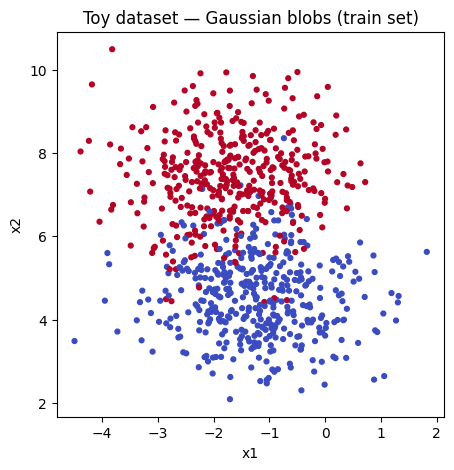

Train shape: (800, 2) Test shape: (200, 2)


In [2]:
# Create a simple 2D toy dataset (two Gaussian blobs) for binary classification
def make_blobs(n_samples=1000, centers=2, dim=2, std=1.0):
    X = []
    y = []
    per_center = n_samples // centers
    for i in range(centers):
        center = np.random.uniform(-5, 5, size=(dim,)) + i*3.0  # separate centers
        pts = np.random.randn(per_center, dim) * std + center
        X.append(pts)
        y += [i] * per_center
    X = np.vstack(X)
    y = np.array(y)
    # shuffle
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

X, y = make_blobs(n_samples=1000, centers=2, dim=2, std=1.0)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Quick plot
plt.figure(figsize=(5,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', s=12)
plt.title("Toy dataset — Gaussian blobs (train set)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Epoch 001 | loss 0.6982 | test_acc 53.50%
Epoch 020 | loss 0.4560 | test_acc 88.00%
Epoch 040 | loss 0.3069 | test_acc 92.00%
Epoch 060 | loss 0.2366 | test_acc 91.00%
Epoch 080 | loss 0.2202 | test_acc 90.00%
Epoch 100 | loss 0.3319 | test_acc 83.50%
Epoch 120 | loss 0.2034 | test_acc 90.50%
Epoch 140 | loss 0.2667 | test_acc 90.00%
Epoch 160 | loss 0.2280 | test_acc 90.50%
Epoch 180 | loss 0.2001 | test_acc 92.00%
Epoch 200 | loss 0.2196 | test_acc 90.00%

Final test accuracy: 90.00%


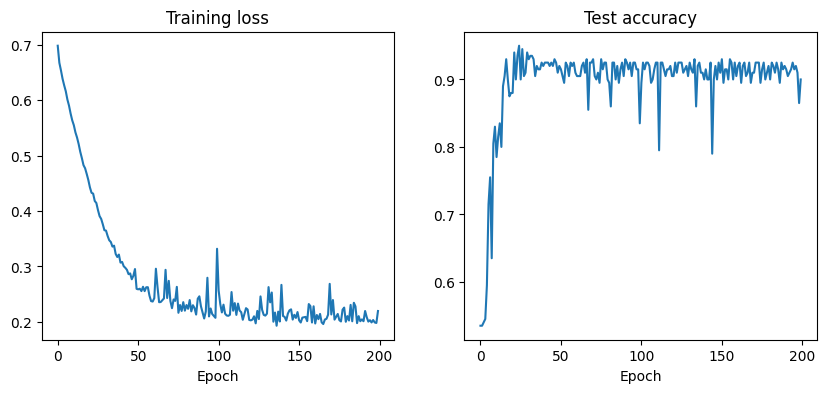

In [3]:
# Two-layer feedforward network (NumPy) + training loop

# ---- model hyperparams ----
input_dim = 2
hidden_dim = 16
output_dim = 2
lr = 0.05
epochs = 200
batch_size = 64

# ---- utility functions ----
def one_hot(y, num_classes):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def accuracy(pred_probs, y_true):
    preds = np.argmax(pred_probs, axis=1)
    return np.mean(preds == y_true)

# ---- initialize weights ----
W1 = np.random.randn(input_dim, hidden_dim) * 0.1
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * 0.1
b2 = np.zeros((1, output_dim))

# ---- prepare data ----
y_train_oh = one_hot(y_train, output_dim)
y_test_oh = one_hot(y_test, output_dim)

# ---- training loop ----
loss_history = []
acc_history = []

n_train = X_train.shape[0]
steps_per_epoch = max(1, n_train // batch_size)

for ep in range(1, epochs+1):
    # shuffle
    idx = np.random.permutation(n_train)
    X_shuf = X_train[idx]
    y_shuf = y_train_oh[idx]
    y_shuf_labels = y_train[idx]
    
    epoch_loss = 0.0
    for s in range(steps_per_epoch):
        start = s * batch_size
        end = start + batch_size
        xb = X_shuf[start:end]
        yb = y_shuf[start:end]
        yb_labels = y_shuf_labels[start:end]
        
        # forward
        z1 = xb.dot(W1) + b1          # (B, H)
        a1 = relu(z1)                 # (B, H)
        z2 = a1.dot(W2) + b2          # (B, C)
        probs = softmax(z2)           # (B, C)
        
        # loss (cross-entropy)
        loss = -np.mean(np.sum(yb * np.log(probs + 1e-12), axis=1))
        epoch_loss += loss
        
        # backward (gradients)
        dz2 = (probs - yb) / xb.shape[0]      # (B, C)
        dW2 = a1.T.dot(dz2)                   # (H, C)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        
        da1 = dz2.dot(W2.T)                   # (B, H)
        dz1 = da1 * relu_deriv(z1)            # (B, H)
        dW1 = xb.T.dot(dz1)                   # (D, H)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        # parameter update (SGD)
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1
    
    # end epoch: evaluate on test set
    # forward on full test
    z1_test = X_test.dot(W1) + b1
    a1_test = relu(z1_test)
    z2_test = a1_test.dot(W2) + b2
    probs_test = softmax(z2_test)
    test_acc = accuracy(probs_test, y_test)
    
    loss_history.append(epoch_loss / steps_per_epoch)
    acc_history.append(test_acc)
    
    if ep % 20 == 0 or ep == 1:
        print(f"Epoch {ep:03d} | loss {loss_history[-1]:.4f} | test_acc {test_acc*100:.2f}%")

# ---- final evaluation and plots ----
print("\nFinal test accuracy:", f"{acc_history[-1]*100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.subplot(1,2,2)
plt.plot(acc_history)
plt.title("Test accuracy")
plt.xlabel("Epoch")
plt.show()


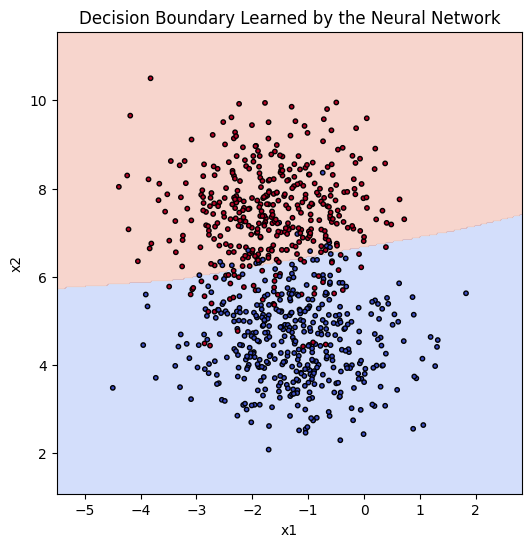

In [4]:
# Visualize decision boundary learned by the network

# create a grid over the space
grid_x1 = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300)
grid_x2 = np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300)
xx, yy = np.meshgrid(grid_x1, grid_x2)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# forward pass on the grid
z1 = grid_points.dot(W1) + b1
a1 = relu(z1)
z2 = a1.dot(W2) + b2
probs = softmax(z2)
preds = np.argmax(probs, axis=1)

# plot
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, preds.reshape(xx.shape), levels=2, alpha=0.3, cmap="coolwarm")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="coolwarm", s=10, edgecolors="k")
plt.title("Decision Boundary Learned by the Neural Network")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



Train: (56000, 784)  Test: (14000, 784)
Epoch 01 | Loss: 2.9045 | Test Acc: 12.46%
Epoch 02 | Loss: 2.7200 | Test Acc: 16.14%
Epoch 03 | Loss: 2.5515 | Test Acc: 20.86%
Epoch 04 | Loss: 2.4000 | Test Acc: 25.86%
Epoch 05 | Loss: 2.2634 | Test Acc: 30.42%
Epoch 06 | Loss: 2.1398 | Test Acc: 34.18%
Epoch 07 | Loss: 2.0291 | Test Acc: 37.14%
Epoch 08 | Loss: 1.9295 | Test Acc: 40.36%
Epoch 09 | Loss: 1.8404 | Test Acc: 43.11%
Epoch 10 | Loss: 1.7591 | Test Acc: 45.71%
Epoch 11 | Loss: 1.6852 | Test Acc: 48.17%
Epoch 12 | Loss: 1.6189 | Test Acc: 50.85%
Epoch 13 | Loss: 1.5575 | Test Acc: 53.16%
Epoch 14 | Loss: 1.5020 | Test Acc: 55.26%
Epoch 15 | Loss: 1.4507 | Test Acc: 57.15%
Epoch 16 | Loss: 1.4034 | Test Acc: 59.11%
Epoch 17 | Loss: 1.3599 | Test Acc: 60.67%
Epoch 18 | Loss: 1.3192 | Test Acc: 61.96%
Epoch 19 | Loss: 1.2822 | Test Acc: 63.22%
Epoch 20 | Loss: 1.2477 | Test Acc: 64.61%
Epoch 21 | Loss: 1.2158 | Test Acc: 65.85%
Epoch 22 | Loss: 1.1851 | Test Acc: 66.89%
Epoch 23 | Los

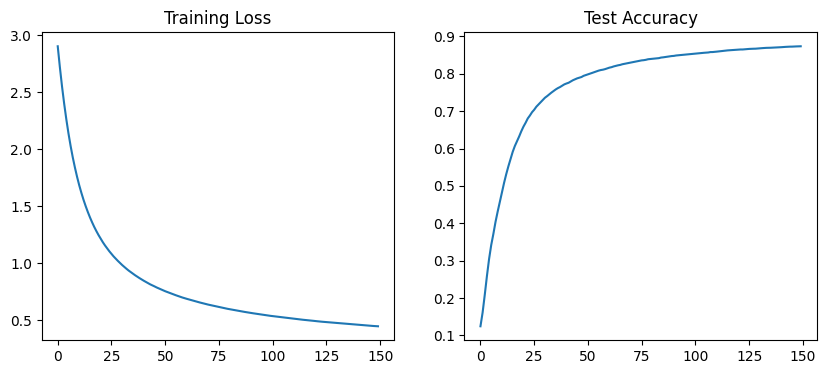

Saved weights to ffnn_mnist.npz
Weights saved successfully


In [5]:
# ---------- self-contained MNIST training block (copy exactly) ----------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# ---- small helpers (self-contained) ----
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)
def one_hot(y, num_classes):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh
def accuracy(pred_probs, y_true):
    preds = np.argmax(pred_probs, axis=1)
    return np.mean(preds == y_true)

# ---- fetch and preprocess ----
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_all = mnist['data'].astype(np.float32) / 255.0        # (70000, 784)
y_all = mnist['target'].astype(int)

# optionally reduce size for speed during testing
# X_all = X_all[:20000]; y_all = y_all[:20000]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
print("Train:", X_train.shape, " Test:", X_test.shape)

# standardize (helps training)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---- model hyperparams ----
input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.0001
epochs = 150   # change higher later if you want
batch_size = 256

# ---- initialize weights ----
W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
b2 = np.zeros((1, output_dim))

y_train_oh = one_hot(y_train, output_dim)
y_test_oh = one_hot(y_test, output_dim)

# ---- training loop ----
n_train = X_train.shape[0]
steps_per_epoch = max(1, n_train // batch_size)

loss_history = []
acc_history = []

for ep in range(1, epochs + 1):
    idx = np.random.permutation(n_train)
    X_shuf = X_train[idx]
    y_shuf = y_train_oh[idx]
    epoch_loss = 0.0

    for s in range(steps_per_epoch):
        start = s * batch_size
        xb = X_shuf[start:start+batch_size]
        yb = y_shuf[start:start+batch_size]
        if xb.shape[0] == 0:
            continue

        # forward
        z1 = xb.dot(W1) + b1
        a1 = relu(z1)
        z2 = a1.dot(W2) + b2
        probs = softmax(z2)

        # loss (cross-entropy)
        loss = -np.mean(np.sum(yb * np.log(probs + 1e-12), axis=1))
        epoch_loss += loss

        # backward
        dz2 = (probs - yb) / xb.shape[0]
        dW2 = a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2.dot(W2.T)
        dz1 = da1 * relu_deriv(z1)
        dW1 = xb.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # sgd update
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1

    # evaluation on test set
    z1_test = X_test.dot(W1) + b1
    a1_test = relu(z1_test)
    z2_test = a1_test.dot(W2) + b2
    probs_test = softmax(z2_test)
    test_acc = accuracy(probs_test, y_test)

    loss_history.append(epoch_loss / steps_per_epoch)
    acc_history.append(test_acc)

    print(f"Epoch {ep:02d} | Loss: {loss_history[-1]:.4f} | Test Acc: {test_acc*100:.2f}%")

# ---- final report ----
print("\nTraining complete.")
print("Final test accuracy:", f"{acc_history[-1]*100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(loss_history); plt.title("Training Loss")
plt.subplot(1,2,2); plt.plot(acc_history); plt.title("Test Accuracy")
plt.show()

# Save model to disk for later use
np.savez('ffnn_mnist.npz', W1=W1, b1=b1, W2=W2, b2=b2)
print("Saved weights to ffnn_mnist.npz")
# ------------------------------------------------------------------------
import numpy as np


np.savez(
    "ffnn_mnist.npz",
    W1=W1,
    b1=b1,
    W2=W2,
    b2=b2
)

print("Weights saved successfully")


In [11]:
print("Final test accuracy:", f"{acc_history[-1]*100:.2f}%")

Final test accuracy: 87.34%


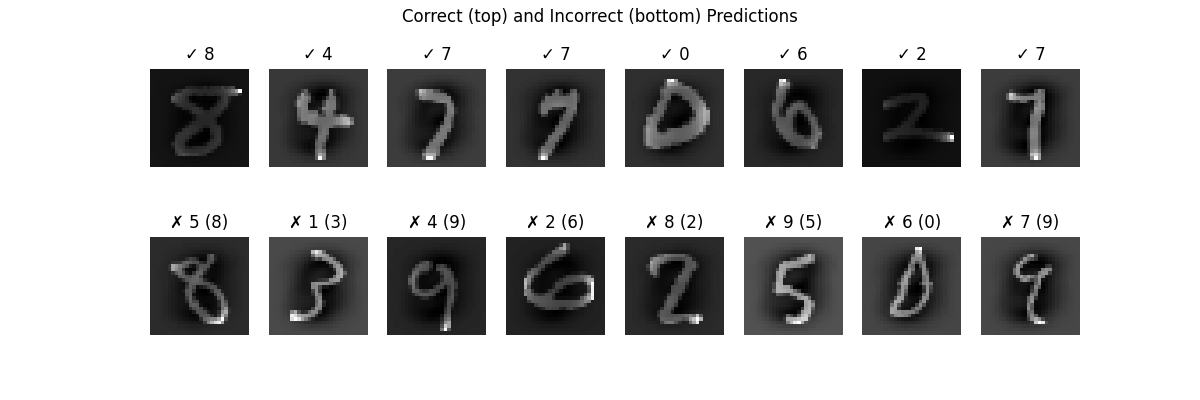

In [12]:
# Visualize some predictions (correct and incorrect)

def predict(x):
    z1 = x.dot(W1) + b1
    a1 = relu(z1)
    z2 = a1.dot(W2) + b2
    probs = softmax(z2)
    return np.argmax(probs, axis=1)

preds = predict(X_test)

# find correct & wrong predictions
correct_idx = np.where(preds == y_test)[0][:8]
wrong_idx   = np.where(preds != y_test)[0][:8]

plt.figure(figsize=(12,4))

# correct predictions
for i, idx in enumerate(correct_idx):
    plt.subplot(2,8,i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"✓ {preds[idx]}")
    plt.axis('off')

# wrong predictions
for i, idx in enumerate(wrong_idx):
    plt.subplot(2,8,8+i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"✗ {preds[idx]} ({y_test[idx]})")
    plt.axis('off')

plt.suptitle("Correct (top) and Incorrect (bottom) Predictions")
plt.show()


In [13]:
from ipycanvas import Canvas


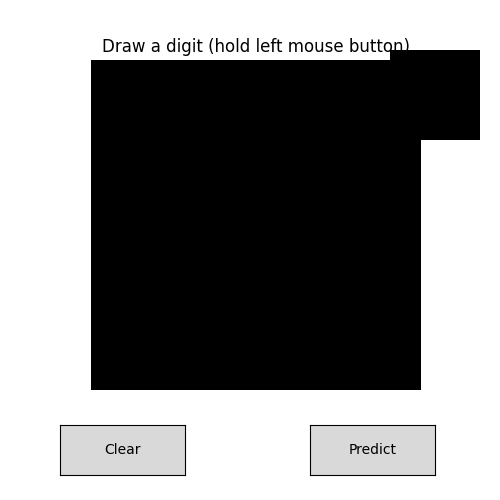

In [30]:
%matplotlib widget
# Single-cell: matplotlib-widget drawing + Clear + Predict (robust)
# Requirements: ipympl installed (for %matplotlib widget). ffnn_mnist.npz must exist or model variables present.

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from PIL import Image
from IPython.display import display, clear_output

# --- load model weights if file exists ---
if os.path.exists("ffnn_mnist.npz"):
    data = np.load("ffnn_mnist.npz")
    W1 = data["W1"]; b1 = data["b1"]; W2 = data["W2"]; b2 = data["b2"]

# rebuild scaler if missing (fast subset fetch)
if 'scaler' not in globals():
    from sklearn.datasets import fetch_openml
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    mnist = fetch_openml("mnist_784", version=1, as_frame=False)
    X_all = mnist["data"].astype(np.float32) / 255.0
    y_all = mnist["target"].astype(int)
    X_small = X_all[:20000]; y_small = y_all[:20000]
    X_train_sc, _, _, _ = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
    scaler = StandardScaler(); scaler.fit(X_train_sc)

# --- helpers ---
def relu(x): return np.maximum(0, x)
def softmax_row(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

# --- drawing surface (numpy image) ---
canvas_size = 280
draw_img = np.zeros((canvas_size, canvas_size), dtype=np.float32)

# --- main figure and axes ---
fig, ax = plt.subplots(figsize=(5,5))
plt.subplots_adjust(bottom=0.22)
im = ax.imshow(draw_img, cmap='gray', vmin=0, vmax=1)
ax.set_title("Draw a digit (hold left mouse button)")
ax.axis("off")

# --- drawing state ---
drawing = False
last_x = None
last_y = None
brush = 10

def draw_dot(x, y):
    global last_x, last_y
    x = int(round(x)); y = int(round(y))
    # draw a filled square/brush
    for dx in range(-brush, brush+1):
        for dy in range(-brush, brush+1):
            xx = x + dx; yy = y + dy
            if 0 <= xx < canvas_size and 0 <= yy < canvas_size:
                draw_img[yy, xx] = 1.0
    # connect to last position for continuity
    if last_x is not None and last_y is not None:
        # simple Bresenham-like interpolation
        steps = max(abs(x-last_x), abs(y-last_y), 1)
        for i in range(1, steps+1):
            xi = int(round(last_x + (x-last_x)*i/steps))
            yi = int(round(last_y + (y-last_y)*i/steps))
            for dx in range(-brush, brush+1):
                for dy in range(-brush, brush+1):
                    xx = xi + dx; yy = yi + dy
                    if 0 <= xx < canvas_size and 0 <= yy < canvas_size:
                        draw_img[yy, xx] = 1.0
    last_x, last_y = x, y
    im.set_data(draw_img)
    fig.canvas.draw_idle()

def on_press(event):
    global drawing
    drawing = True
    if event.xdata is not None and event.ydata is not None:
        draw_dot(event.xdata, event.ydata)

def on_release(event):
    global drawing, last_x, last_y
    drawing = False
    last_x = None; last_y = None

def on_move(event):
    if drawing and event.xdata is not None and event.ydata is not None:
        draw_dot(event.xdata, event.ydata)

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('motion_notify_event', on_move)

# --- buttons on same figure ---
clear_ax = fig.add_axes([0.12, 0.05, 0.25, 0.10])
predict_ax = fig.add_axes([0.62, 0.05, 0.25, 0.10])
clear_btn = Button(clear_ax, "Clear")
predict_btn = Button(predict_ax, "Predict")

# --- inset for showing processed 28x28 and text display ---
pred_ax = fig.add_axes([0.78, 0.72, 0.18, 0.18])
pred_ax.axis('off')
pred_im = pred_ax.imshow(np.zeros((28,28)), cmap='gray', vmin=0, vmax=1)
if hasattr(fig, "_pred_text"):
    try: fig._pred_text.remove()
    except: pass
fig._pred_text = fig.text(0.5, 0.02, "", ha='center', va='center', fontsize=14,
                          color='yellow', bbox=dict(facecolor='black', alpha=0.6))

# --- button callbacks ---
def clear_canvas(event):
    global draw_img
    draw_img = np.zeros((canvas_size, canvas_size), dtype=np.float32)
    im.set_data(draw_img); fig.canvas.draw_idle()
    fig._pred_text.set_text("")
    pred_im.set_data(np.zeros((28,28)))
    with_out = getattr(clear_canvas, "out", None)
    if with_out is None:
        print("Canvas cleared.")
    else:
        with_out.clear_output(wait=True)
        with with_out:
            print("Canvas cleared.")

def predict_display(event):
    try:
        # prepare image
        pil = Image.fromarray((draw_img*255).astype(np.uint8))
        pil28 = pil.resize((28,28), resample=Image.BILINEAR).convert("L")
        arr = np.array(pil28).astype(np.float32) / 255.0
        arr_flat = arr.flatten()
        arr_scaled = scaler.transform([arr_flat])[0]
        z1 = arr_scaled.dot(W1) + b1
        a1 = relu(z1)
        z2 = a1.dot(W2) + b2
        probs = softmax_row(z2.reshape(1,-1))
        pred = int(np.argmax(probs)); conf = float(np.max(probs))
        pred_im.set_data(arr)
        fig._pred_text.set_text(f"Pred: {pred}  conf:{conf:.2f}")
        fig.canvas.draw_idle()
    except Exception as e:
        fig._pred_text.set_text("Error: " + str(e)); fig.canvas.draw_idle()

clear_btn.on_clicked(clear_canvas)
predict_btn.on_clicked(predict_display)

plt.show()


In [32]:
# STEP 2: Use the existing drawing to predict with the Spiking Neural Network

from PIL import Image

def snn_predict_from_draw():
    # prepare image exactly like FFNN
    pil = Image.fromarray((draw_img*255).astype(np.uint8)).resize((28,28))
    arr = np.array(pil).astype(np.float32) / 255.0
    arr = arr.flatten()
    arr = scaler.transform([arr])[0]

    pred = snn_predict(arr)
    return pred

# add a new button for SNN
snn_ax = fig.add_axes([0.37, 0.05, 0.25, 0.10])
snn_btn = Button(snn_ax, "Predict (SNN)")

def snn_button(event):
    p = snn_predict_from_draw()
    fig._pred_text.set_text(f"SNN Pred: {p}")
    fig.canvas.draw_idle()

snn_btn.on_clicked(snn_button)

print("SNN button added")


SNN button added


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_snn_spike_raster_from_draw(
    time_steps=40, decay=0.9, threshold=1.0
):
    # ---- convert drawn image to MNIST-like input ----
    pil = Image.fromarray((draw_img * 255).astype(np.uint8))
    pil = pil.resize((28, 28), resample=Image.BILINEAR).convert("L")
    x = np.array(pil).astype(np.float32) / 255.0
    x = scaler.transform([x.flatten()])[0]

    # ---- initialize membrane potentials ----
    v1 = np.zeros(W1.shape[1])
    v2 = np.zeros(W2.shape[1])
    v3 = np.zeros(W2.shape[1])  # same size as hidden layer

    spike_times = []
    spike_neurons = []

    # ---- simulate spikes over time ----
    for t in range(time_steps):
        input_spikes = (x > np.random.rand(x.size)).astype(float)

        v1 = decay * v1 + input_spikes @ W1
        s1 = (v1 > threshold).astype(float)
        v1[s1 > 0] = 0

        v2 = decay * v2 + s1 @ W2
        s2 = (v2 > threshold).astype(float)
        v2[s2 > 0] = 0

        for idx in np.where(s2 > 0)[0]:
            spike_times.append(t)
            spike_neurons.append(idx)

    # ---- raster plot ----
    plt.figure(figsize=(8, 4))
    plt.scatter(spike_times, spike_neurons, s=10, color="black")
    plt.xlabel("Time step")
    plt.ylabel("Neuron index")
    plt.title("Spiking Neural Activity Raster Plot")
    plt.show()


In [34]:
def snn_spike_visualization(x):
    T = 50
    threshold = 1.0
    decay = 0.95

    # match YOUR ACTUAL MODEL SHAPES
    v1 = np.zeros(W1.shape[1])   # hidden
    v2 = np.zeros(W2.shape[1])   # output (10)

    spike_count = np.zeros(W2.shape[1])  # 10 classes

    for t in range(T):
        # Poisson encoding
        input_spikes = (np.random.rand(x.shape[0]) < x).astype(float)

        # Layer 1
        v1 = decay * v1 + input_spikes @ W1
        s1 = (v1 >= threshold).astype(float)
        v1[v1 >= threshold] = 0

        # Output layer (spiking)
        v2 = decay * v2 + s1 @ W2
        s2 = (v2 >= threshold).astype(float)
        v2[v2 >= threshold] = 0

        spike_count += s2

    return spike_count


In [35]:
print("W1 stats:", np.min(W1), np.max(W1))
print("W2 stats:", np.min(W2), np.max(W2))


W1 stats: -0.23233075385924218 0.22676420302713576
W2 stats: -0.3237791897043894 0.3386776254029133


/var/folders/xj/btcj4x1d53l_g0qq5_tp68q80000gn/T/ipykernel_2594/2146952894.py:26: RuntimeWarning: divide by zero encountered in matmul
  v1 = decay * v1 + input_spikes @ W1
/var/folders/xj/btcj4x1d53l_g0qq5_tp68q80000gn/T/ipykernel_2594/2146952894.py:26: RuntimeWarning: overflow encountered in matmul
  v1 = decay * v1 + input_spikes @ W1
/var/folders/xj/btcj4x1d53l_g0qq5_tp68q80000gn/T/ipykernel_2594/2146952894.py:26: RuntimeWarning: invalid value encountered in matmul
  v1 = decay * v1 + input_spikes @ W1
/var/folders/xj/btcj4x1d53l_g0qq5_tp68q80000gn/T/ipykernel_2594/2146952894.py:30: RuntimeWarning: divide by zero encountered in matmul
  v2 = decay * v2 + s1 @ W2
/var/folders/xj/btcj4x1d53l_g0qq5_tp68q80000gn/T/ipykernel_2594/2146952894.py:30: RuntimeWarning: overflow encountered in matmul
  v2 = decay * v2 + s1 @ W2
/var/folders/xj/btcj4x1d53l_g0qq5_tp68q80000gn/T/ipykernel_2594/2146952894.py:30: RuntimeWarning: invalid value encountered in matmul
  v2 = decay * v2 + s1 @ W2


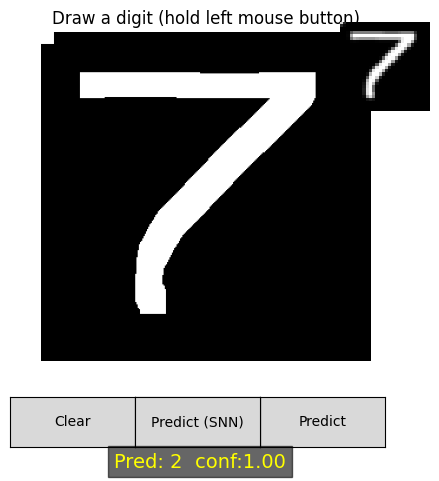

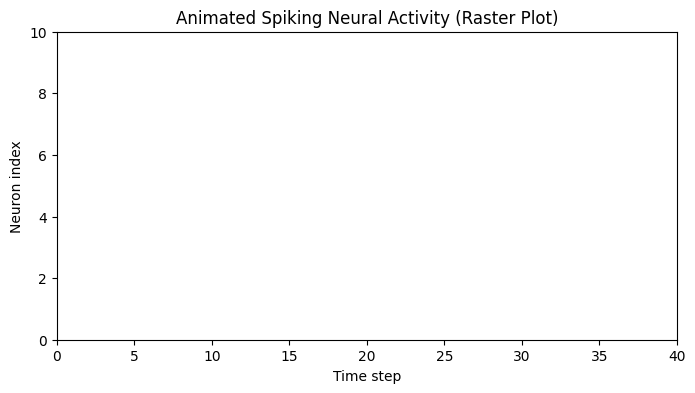

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

def visualize_animated_snn_raster(
    time_steps=40, decay=0.9, threshold=1.0
):
    # ---- preprocess drawn digit ----
    pil = Image.fromarray((draw_img * 255).astype(np.uint8))
    pil = pil.resize((28, 28), resample=Image.BILINEAR).convert("L")
    x = np.array(pil).astype(np.float32) / 255.0
    x = scaler.transform([x.flatten()])[0]

    # ---- initialize membrane potentials ----
    v1 = np.zeros(W1.shape[1])
    v2 = np.zeros(W2.shape[1])

    spike_log = []  # (time, neuron_index)

    # ---- simulate spiking ----
    for t in range(time_steps):
        input_spikes = (x > np.random.rand(x.size)).astype(float)

        v1 = decay * v1 + input_spikes @ W1
        s1 = (v1 > threshold).astype(float)
        v1[s1 > 0] = 0

        v2 = decay * v2 + s1 @ W2
        s2 = (v2 > threshold).astype(float)
        v2[s2 > 0] = 0

        for idx in np.where(s2 > 0)[0]:
            spike_log.append((t, idx))

    if not spike_log:
        print("No spikes detected. Try drawing darker or thicker.")
        return

    spike_log = np.array(spike_log)
    times = spike_log[:, 0]
    neurons = spike_log[:, 1]

    # ---- color coding (early vs late neurons) ----
    colors = np.where(neurons < neurons.max() / 2, "tab:blue", "tab:red")

    # ---- animation setup ----
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlim(0, time_steps)
    ax.set_ylim(0, W2.shape[1])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Neuron index")
    ax.set_title("Animated Spiking Neural Activity (Raster Plot)")

    scatter = ax.scatter([], [], s=15)

    def update(frame):
        mask = times <= frame
        scatter.set_offsets(np.c_[times[mask], neurons[mask]])
        scatter.set_color(colors[mask])
        return scatter,

    ani = FuncAnimation(
        fig, update, frames=time_steps, interval=150, blit=True
    )

    plt.show()

# ---- run ----
visualize_animated_snn_raster()


In [37]:
visualize_snn_spikes_from_draw()


NameError: name 'visualize_snn_spikes_from_draw' is not defined